# Data Story

The data (Bondora's loan book) can be download from: https://www.bondora.com/marketing/media/LoanData.zip

In [25]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

pd.options.display.max_rows = 125

In [26]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={"figure.figsize": (16, 4)})

In [64]:
loandata = pd.read_csv("data/loandata.csv", low_memory=False)
loandata['year'] = pd.to_datetime(loandata['ListedOnUTC']).dt.year
loandata['yearmonth'] = pd.to_datetime(loandata['ListedOnUTC']).dt.to_period('M')
recentld = loandata[loandata['year'] > 2012]
repaid = recentld[recentld['Status'] == 'Repaid']

In [28]:
(loandata.shape, recentld.shape)

((35513, 114), (32779, 114))

### Number of loans per year

In [29]:
countByYear = loandata.groupby('year').size()

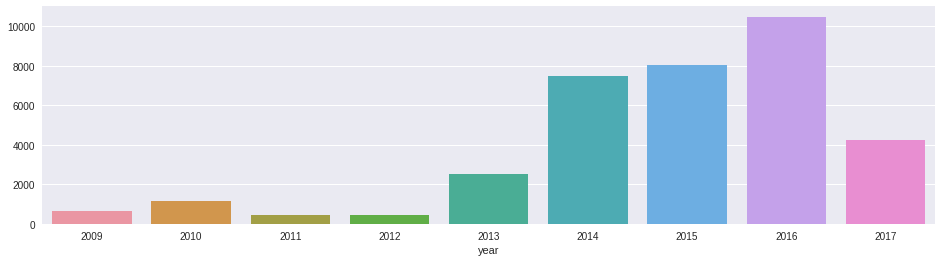

In [30]:
plot = sns.barplot(x=countByYear.index,y=countByYear)

From the initial analysis we can see that the number of loans is definitely growing over time. This can be caused by a higher demand for loans or rise in popularity of Bondora.

### Median salary per year and country

In [32]:
t = loandata[['year', 'IncomeTotal', 'Country']]
t = t[(t['year'] > 2010) & (t['year'] < 2017)]

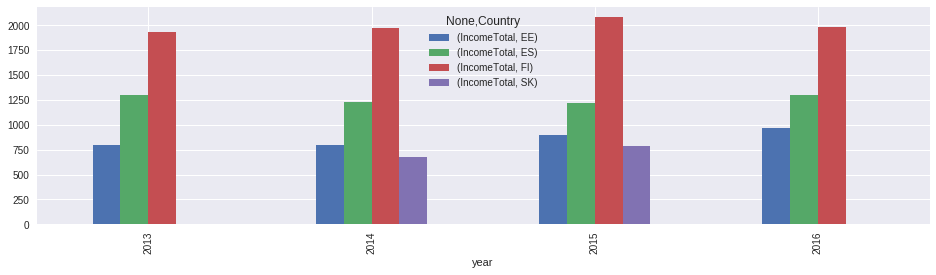

In [33]:
plot = t.groupby(['year', 'Country']).median().unstack(1).plot(kind='bar', figsize=(16, 4))

We can see that, generally, the income of the borrowers increases over time. This is an expected behaviour as the countries, where Bondora operates, have seen an increase of average salary over the last years. 

### Loan amount analysis

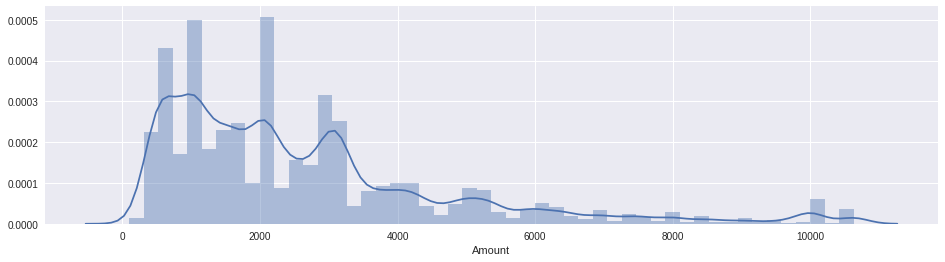

In [34]:
plot = sns.distplot(loandata['Amount'].astype(int), bins=50)

#### List of the top 30 loan amount (round to nearest 100) with counts:

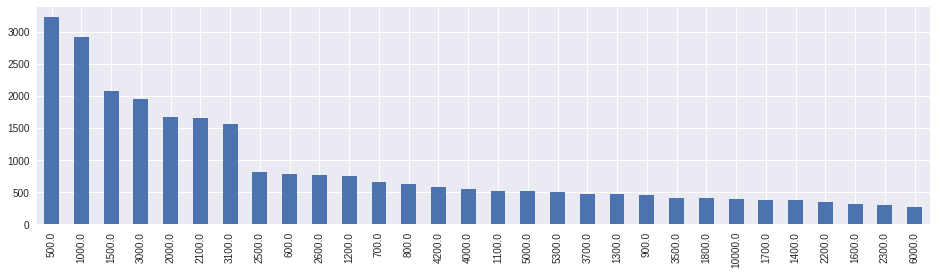

In [35]:
plot = (loandata['Amount'] // 100 * 100).value_counts().head(30).plot(kind='bar')

The most common loan amount is 500 EUR with the first 13 being lower or equal to 3100 EUR.

#### Distributions of loan amounts over years

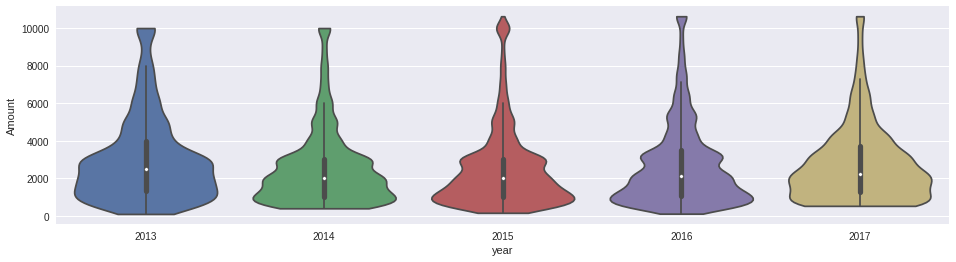

In [36]:
plot = sns.violinplot(cut=0, scale="width", x="year", y="Amount", data=loandata[['Amount', 'year']])

In the first couple of years the loans were relatively much lower then in the last years. Average, minimum and maximum loan amounts increase over time.

#### Distribution of loan amounts per country

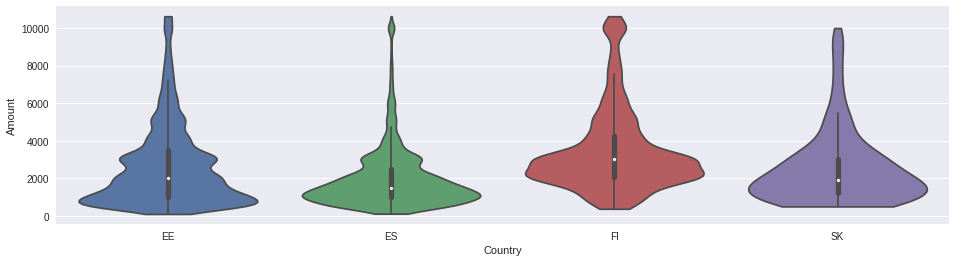

In [37]:
plot = sns.violinplot(cut=0, scale="width", x="Country", y="Amount", data=loandata[['Amount', 'Country']])

Finland has the highest most frequent loan amount (about 2100 EUR) and Estonia the lowest (about 500 EUR). The shapes of the distrubtions are similar across all the countries.

### Loan duration analysis

In [38]:
pd.options.mode.chained_assignment = None  # default='warn'
t = loandata[['Amount', 'LoanDuration']]
t['LoanDuration2'] = t['LoanDuration'] // 12 * 12

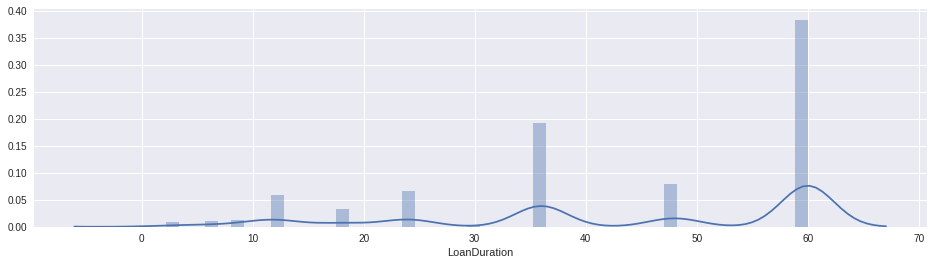

In [39]:
plot = sns.distplot(loandata['LoanDuration'], bins=50) # remove density

#### Loan duration with relation to the amount

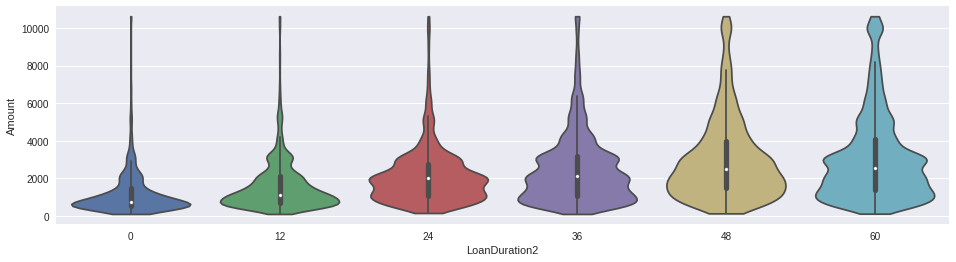

In [40]:
plot = sns.violinplot(cut=0, scale="width", x="LoanDuration2", y="Amount", data=t)

There is a visible linear dependency between the amount borrowed and loan duration -- the longer the loan the higher amount borrowed.

#### Loan duration with relation to year of issue

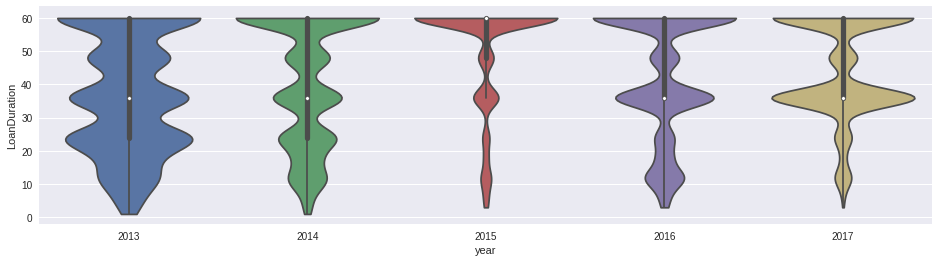

In [41]:
plot = sns.violinplot(cut=0, scale="width", x="year", y="LoanDuration", data=loandata[['year', 'LoanDuration']])

Over the first three years Bondora issued loans of maximum 24 months duration, but since 2013 the maximum duration is 60 months. We can see that the most popular durations in the recent years are 36 and 60 months with very few borrowers choosing durations lower than 12 months.

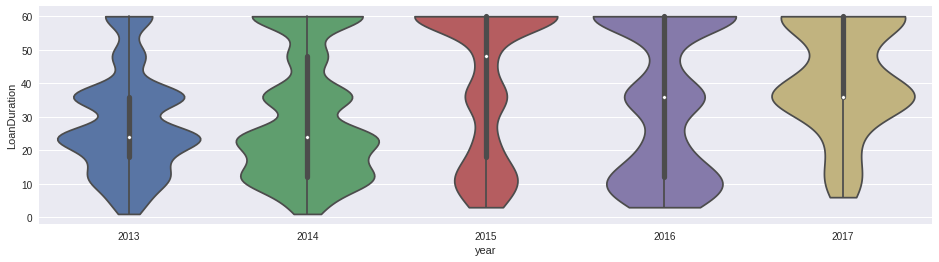

In [65]:
plot = sns.violinplot(cut=0, scale="width", x="year", y="LoanDuration", data=repaid[['year', 'LoanDuration']])

### Number of dependants vs age

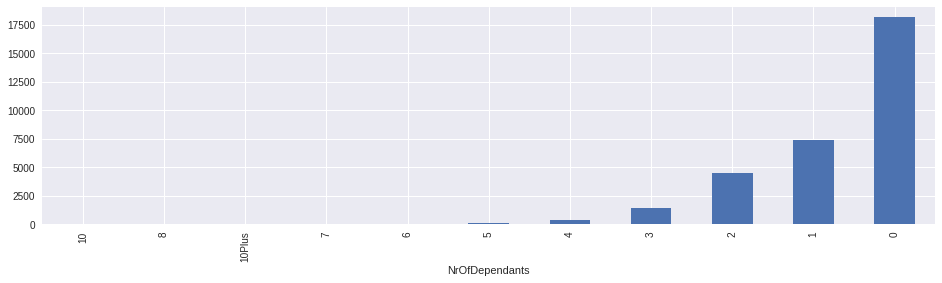

In [42]:
p = loandata[['Age', 'NrOfDependants']]
p['DepNum'] = pd.to_numeric(loandata.NrOfDependants, errors='coerce')
plot = p.groupby('NrOfDependants').size().sort_values().plot(kind='bar')

More than half of the borrowers have no dependants at all with very few borrowers have more than 5 dependants.

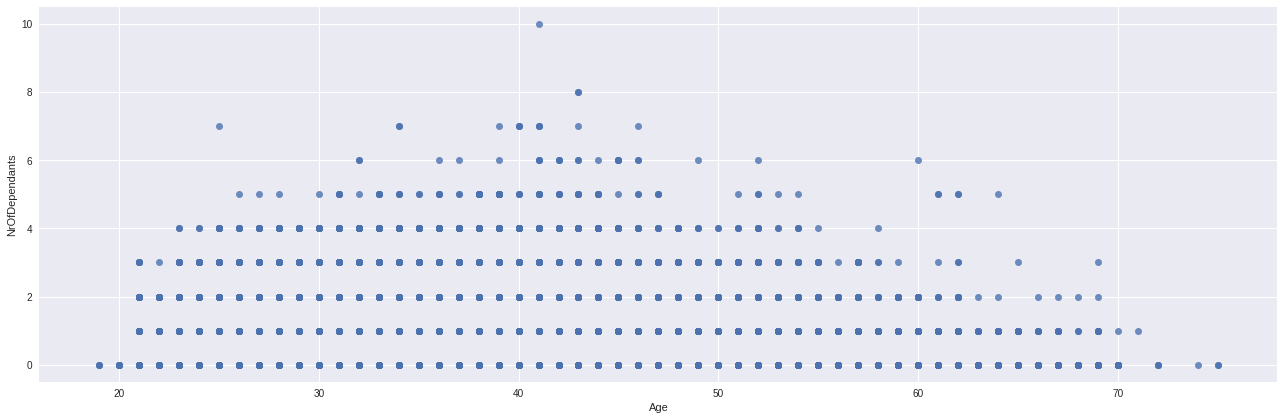

In [70]:
p = p.dropna().astype(int)
grid = sns.lmplot(x="Age", y="NrOfDependants", data=p, fit_reg=False, size=6, aspect=3)

We can see a non linear dependency between the age of the borrower and number of the dependants, gradually increasing from the age of 18, reaching peak between 40-45, and then gradually decreasing.

### Number of loans listed per year month

In [44]:
loandata['yearmonth'] = pd.to_datetime(loandata['ListedOnUTC']).dt.to_period('M')

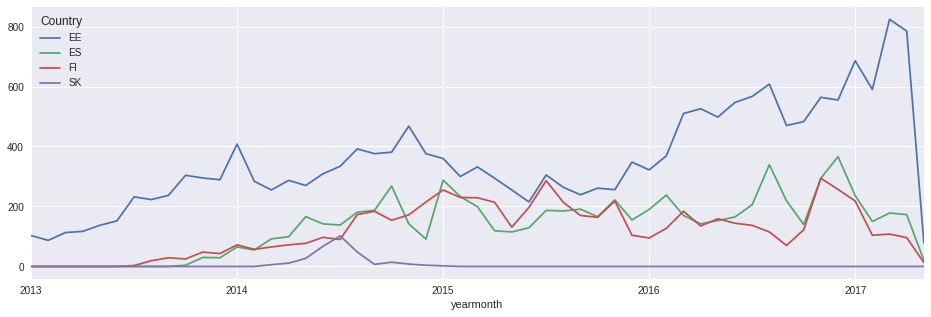

In [45]:
plot = loandata.groupby(['yearmonth', 'Country']).size().unstack(1).sort_index(ascending=True).fillna(0).plot(figsize=(16, 5))

From the analysis of the loans listed per yearmonth, it is clearly visible, that Slovakian loans were listed only for a short period of time (mostly 2014) and since then borrowing from that country has been phased out.

### Distribution of loan amounts for genders

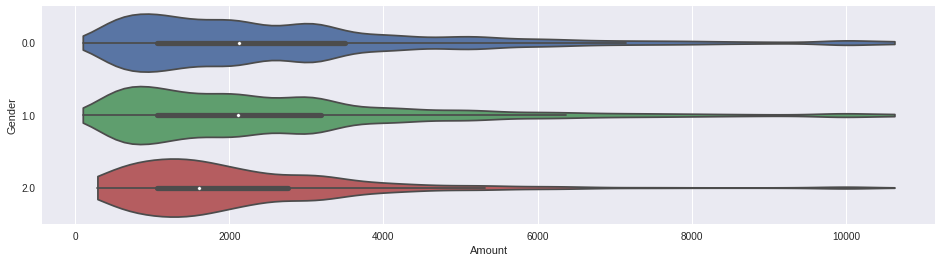

In [46]:
plot = sns.violinplot(cut=0, scale="width", x="Amount", y="Gender", orient='h', data=recentld)

In [47]:
df = recentld
m = df[df['Gender'] == 0.0]
f = df[df['Gender'] == 1.0]
(m.shape, f.shape)

((17369, 114), (13501, 114))

In [48]:
v = 'Amount'

m_mean = m[v].dropna().mean()
f_mean = f[v].dropna().mean()
std = df[v].dropna().std()
z = (m_mean - f_mean) / std
(m_mean, f_mean, std, m_mean - f_mean, z)

(2745.6839196269216,
 2631.183838234205,
 2137.562338978778,
 114.50008139271677,
 0.05356572732630538)

H0: No difference between mean loan amount for female borrowers and male borrowers. H1 - there is a difference.

### Historical repayment rate of principal and amount of interest with penalties

In [53]:
repaid['Defaulted'] = repaid['PrincipalPaymentsMade'] < repaid['Amount'] 
repaid[['Defaulted', 'PrincipalPaymentsMade', 'InterestAndPenaltyPaymentsMade', 'Amount', 'Interest']]

,Defaulted,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,Amount,Interest
7,False,1000.00,403.89,1000.0,61.49
8,False,4000.00,1567.36,4000.0,31.01
10,False,2000.00,575.44,2000.0,17.11
11,False,530.00,130.03,530.0,25.68
13,False,6900.00,3.74,6900.0,21.63
18,False,3720.00,512.48,3720.0,26.94
29,False,1500.00,204.25,1500.0,15.91
49,False,3590.00,14.59,3590.0,21.29
53,False,3720.00,331.42,3720.0,31.12
54,False,2655.00,670.46,2655.0,34.57


In [59]:
print(repaid.shape)
print(repaid['Defaulted'].mean())

(7167, 115)
0.0293009627459


In [63]:
print(repaid['PrincipalPaymentsMade'].sum() / repaid['Amount'].sum())
print(repaid['InterestAndPenaltyPaymentsMade'].sum() / repaid['Amount'].sum())
print((repaid['PrincipalPaymentsMade'].sum() + repaid['InterestAndPenaltyPaymentsMade'].sum()) / repaid['Amount'].sum())


0.9859871652215287
0.23997421529014298
1.2259613805116716
